<a href="https://colab.research.google.com/github/PatrizioPerugini/MOD_VISIOPE/blob/main/proj_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GIT CLONE & DRIVE & DATASET 

In [ ]:
#Clone git repository
!git clone https://github.com/PatrizioPerugini/MOD_VISIOPE.git

Cloning into 'MOD_VISIOPE'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 71 (delta 31), reused 6 (delta 2), pack-reused 0
Unpacking objects: 100% (71/71), done.


**Mount Google Drive**


In [ ]:
from google.colab import drive
ROOT = "/content/drive"         
drive.mount(ROOT)   

Mounted at /content/drive


**Import zip files**

In [ ]:
#zip the file
import zipfile


zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Vision_lab/Chess_dataset_augmented_rebalanced.coco.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/content/MOD_VISIOPE') 
zip_ref.close()

#IMPORT

In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys

In [ ]:
#import pytorch 
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt

In [ ]:
%cd /content/MOD_VISIOPE/
%ls

/content/MOD_VISIOPE
Chess_ds.coco.zip      images/            README.dataset.txt   test/   weights/
Chess_ds_N.coco.zip    project.ipynb      README.md            train/
Chess_ds_new.coco.zip  proj_vision.ipynb  README.roboflow.txt  valid/


In [ ]:
!pip install -U torchvision 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
print(torch.__version__)
print(torchvision.__version__)

1.12.0+cu102
0.13.0+cu102


In [ ]:
# our dataset is in cocoformat, we will need pypcoco tools
!pip install pycocotools
from pycocotools.coco import COCO

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# LOAD AND PREPROCESS THE DATASET

In [ ]:
#Just define a function that transforms our input data
def get_transforms(blur=False):
    if blur:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            #torchvision.transforms
            A.GaussianBlur(7,(1.0, 2.0)),
            A.RandomBrightnessContrast(p=0.2),
            #A.ColorJitter(p=0.2),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [ ]:
class Chess_ds(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
       
        super().__init__(root, transforms, transform, target_transform)
        self.split = split 
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json"))
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target] 
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            ymin = box[1]
            xmax = xmin + box[2]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {} 
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) 
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [ ]:
#load classes
dataset_path = "/content/MOD_VISIOPE/"
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!


{0: {'id': 0, 'name': 'Chess', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'bishop', 'supercategory': 'Chess'},
 2: {'id': 2, 'name': 'black-bishop', 'supercategory': 'Chess'},
 3: {'id': 3, 'name': 'black-king', 'supercategory': 'Chess'},
 4: {'id': 4, 'name': 'black-knight', 'supercategory': 'Chess'},
 5: {'id': 5, 'name': 'black-pawn', 'supercategory': 'Chess'},
 6: {'id': 6, 'name': 'black-queen', 'supercategory': 'Chess'},
 7: {'id': 7, 'name': 'black-rook', 'supercategory': 'Chess'},
 8: {'id': 8, 'name': 'white-bishop', 'supercategory': 'Chess'},
 9: {'id': 9, 'name': 'white-king', 'supercategory': 'Chess'},
 10: {'id': 10, 'name': 'white-knight', 'supercategory': 'Chess'},
 11: {'id': 11, 'name': 'white-pawn', 'supercategory': 'Chess'},
 12: {'id': 12, 'name': 'white-queen', 'supercategory': 'Chess'},
 13: {'id': 13, 'name': 'white-rook', 'supercategory': 'Chess'}}

In [ ]:
classes = [i[1]['name'] for i in categories.items()]
labels = [i[1]['id'] for i in categories.items()]
print(labels)
print(classes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
['Chess', 'bishop', 'black-bishop', 'black-king', 'black-knight', 'black-pawn', 'black-queen', 'black-rook', 'white-bishop', 'white-king', 'white-knight', 'white-pawn', 'white-queen', 'white-rook']


In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_dataset_blur = Chess_ds(root=dataset_path, transforms=get_transforms(True))
train_loader_blur = DataLoader(train_dataset_blur, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [ ]:
#create train
train_dataset = Chess_ds(root=dataset_path, transforms=get_transforms(False))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [ ]:
#create validation
validation_dataset = Chess_ds(root=dataset_path, split="valid", transforms=get_transforms(False))
valid_dl = DataLoader(validation_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:
validation_dataset_blur = Chess_ds(root=dataset_path, split="valid", transforms=get_transforms(True))
valid_dl_blur = DataLoader(validation_dataset_blur, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


tensor([1511])


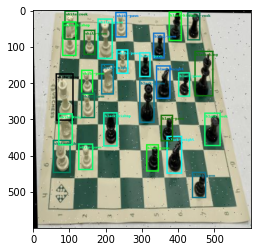

In [ ]:
# As good practice, let's view a sample! 
i=torch.randint(1,len(train_dataset),(1,))
sample = train_dataset[i]
print(i)
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [ ]:
len(train_dataset)

1707

# CHOOSE A FASTER R-CNN

In [ ]:
# lets load the faster rcnn model with mobilenetV3
weight_path = "/content/drive/MyDrive/Vision_lab/weights/rcnn_mobilenetV3_weights.pt"

model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)


model.load_state_dict(torch.load(weight_path))

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
# lets load the faster rcnn model with ResNet
weight_path = "/content/drive/MyDrive/Vision_lab/weights/rcnn_resnet50_weights.pt"

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)


model.load_state_dict(torch.load(weight_path))

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
# lets load the faster R-CNN model with mobilenetV3 large
weight_path = "/content/drive/MyDrive/Vision_lab/weights/rcnn_mobilenetV3_large_weights.pt"

model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)


model.load_state_dict(torch.load(weight_path))



Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
device = torch.device("cuda") # use GPU to train

In [ ]:
model = model.to(device)

In [ ]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]

#output = model(images, targets) 

targets = [{k: torch.tensor(v) for k, v in t.items()} for t in targets]

# OPTIMIZER

In [ ]:
def fit(model, optimizer, loader, device,val,num_epochs):
    model.to(device)
    model.train()
    loss_4plot = []
    loss_val_4plot = []
    
    for epoch in range(num_epochs):
      all_losses = []
      all_losses_dict = []
      all_losses_v = []
      all_losses_dict_v = []
      #
      for images, targets in tqdm(loader):
          images = list(image.to(device) for image in images)
          targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
          loss_dict = model(images, targets) 
          
          #print(type(loss_dict)) ... class dict
          losses = sum(loss for loss in loss_dict.values())
          loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
          loss_value = losses.item()
        
          all_losses.append(loss_value)
          all_losses_dict.append(loss_dict_append)
        
          optimizer.zero_grad()
          losses.backward()
          optimizer.step()
        
     
      #IN ORDER TO SEE IF THE MODEL OVERFITS WE HAVE TO CHECK IF 
      #THE TRAINING ERROR IS DECREASING WHILE THE
      #VALIDATION ERROR IS INCREASING
     

      for images, targets in (val):
          images = list(image.to(device) for image in images)
          targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
          loss_dict = model(images, targets) 
         
          
          losses = sum(loss for loss in loss_dict.values())
         
          loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
          loss_value = losses.item()
        
          all_losses_v.append(loss_value)
          all_losses_dict_v.append(loss_dict_append)
      
      all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
      print("Epoch {}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
            epoch,np.mean(all_losses),
            all_losses_dict['loss_classifier'].mean(),
            all_losses_dict['loss_box_reg'].mean(),
            all_losses_dict['loss_rpn_box_reg'].mean(),
            all_losses_dict['loss_objectness'].mean()
            
       ))
      
      loss_4plot.append(np.mean(all_losses))
      

      all_losses_dict_v = pd.DataFrame(all_losses_dict_v) # for printing
      print("Epoch {}, loss_val: {:.6f}, loss_classifier_val: {:.6f}, loss_box_val: {:.6f}, loss_rpn_box_val: {:.6f}, loss_object_v: {:.6f}".format(
            epoch,np.mean(all_losses_v),
            all_losses_dict_v['loss_classifier'].mean(),
            all_losses_dict_v['loss_box_reg'].mean(),
            all_losses_dict_v['loss_rpn_box_reg'].mean(),
            all_losses_dict_v['loss_objectness'].mean()
            
       ))
      
      loss_val_4plot.append(np.mean(all_losses_v))
     
      


      torch.save(model.state_dict(), weight_path)
      
    ep = np.arange(0, num_epochs, 1, dtype=int)

    plt.plot(ep, loss_4plot, label = "loss on trainig")
    plt.plot(ep, loss_val_4plot, label = "loss on validation")
    plt.legend()
    plt.show()    

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]

#we can try and change the optimizer or its parameters but it works just fine
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
#we can train with small number of epochs, we'll save each intermediate weights
num_epochs=3


In [ ]:
#fit the model
fit(model, optimizer, train_loader, device,valid_dl,num_epochs)
 
torch.save(model.state_dict(), weight_path)

In [ ]:
#Just to get a peek... don't run :)
print("Model's state_dict:")
for p_t in model.state_dict():
    print(p_t, "\t", model.state_dict()[p_t].size())


# EVALUATE

**In this last part we'll show how our model behaves in different situations**

In [ ]:
model.eval()
torch.cuda.empty_cache()

In [ ]:
test_dataset = Chess_ds(root=dataset_path, split="test", transforms=get_transforms(False))#rather then false
len(test_dataset)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


27

In [ ]:
def make_pred(img,lower_th=False):
  #since we don't have to compute the loss we don't require the gradients to be computed
  th=0.8
  if(lower_th):
    th=0.5
  img_int = torch.tensor(img*255, dtype=torch.uint8)
  with torch.no_grad():
      prediction = model([img.to(device)])
      pred = prediction[0]

  fig = plt.figure(figsize=(14, 10))
  plt.imshow(draw_bounding_boxes(img_int,
      pred['boxes'][pred['scores'] > th],
      [classes[i] for i in pred['labels'][pred['scores'] > th].tolist()], width=4##0.8
  ).permute(1, 2, 0))

**PREDICTION ON A SAMPLES OF THE ORIGINAL DATASET**

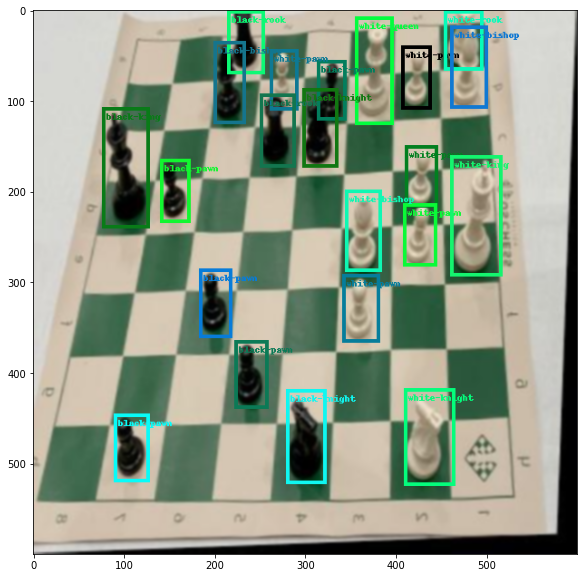

In [ ]:
img, _ = test_dataset[12]
make_pred(img)


**PREDICTION ON A SAMPLE FROM THE AUGMENTED DATASET**

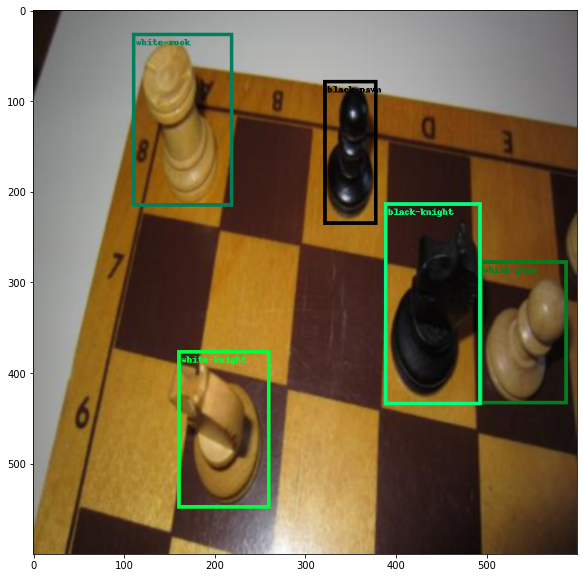

In [ ]:
img, _ = test_dataset[61]
make_pred(img)

**FAILURE**

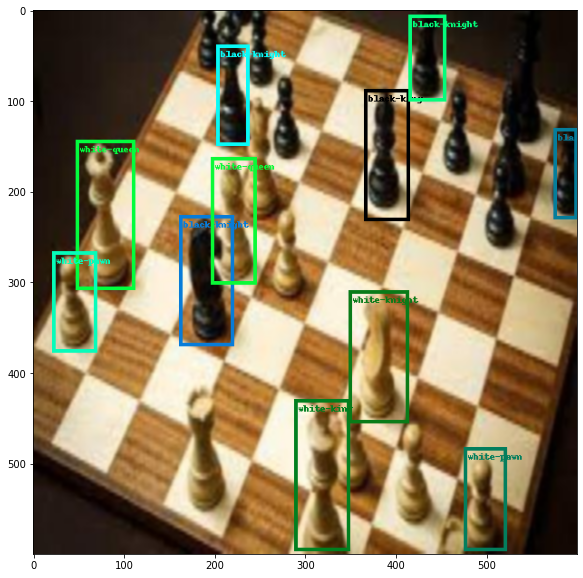

In [ ]:
img, _ = test_dataset[74]
make_pred(img)

**PLAY WITH RANDOM EXAMPLES!**

In [ ]:
i =torch.randint(1,len(test_dataset)-1,(1,))
print(i)
img, _ = test_dataset[i]
make_pred(img)


**WHAT IF WE DECIDE TO DECREASE THE THRESHOLD?**

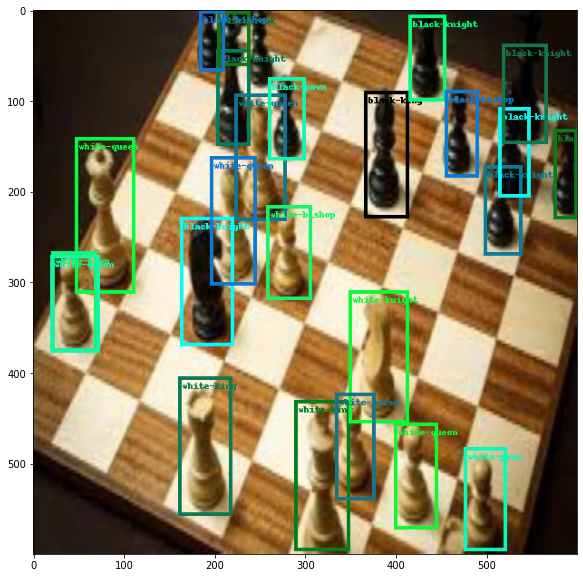

In [ ]:
img, _ = test_dataset[74]
make_pred(img,lower_th=True)
##we have many more predicted bounding boxes..but they are wrong


In [ ]:
def Mean_Acc(pred,yb): #pred is the prediction, yb is the true value
#pred=[[1,2,3],[14,5]]
    cnt=0
    for i in range(len(pred)):
        if((pred[i].shape)==(yb[i].shape)):
          cnt+=1
    return cnt/len(pred)

def Mse_Acc(pred,yb):
    cnt=0
    for i in range(len(pred)):
          cnt=cnt + (yb[i].shape[0] - len(pred[i]))**2
    return cnt**0.5 / (len(pred) -1)
#get the number of bb, we'll need them to normalize
def Num_Bb(yb):
    sum = 0
    for i in range(len(yb)):
        sum+=yb[i].shape[0]
    return sum
def Mean_Acc_Mse_class(pred,yb):
    ris = 0
    num_bb = Num_Bb(yb)
    mse = 0
    for i in range(len(yb)):
        single_mse_error = 0
       
        for j in range(len(pred[i])):
            #if(ll_copy[i][j] in pred[i]):
            fp=0
            if(pred[i][j] in yb[i]):
                ris+=1
            else:
              single_mse_error+=1
      
    return ris/num_bb #return the average approximated accuracy of corrected classified samples and a mse
def IoU_bb(scores):
  summ=0
  nbb=0
  for i in range(len(scores)):
    summ+=sum(scores[i])
    nbb+=len(scores[i])
  return summ/nbb




In [ ]:
l=[]
pred_list=[]
yb_list=[]
scores=[] 
for i in range(len(test_dataset)):
  with torch.no_grad():
    img, targets =test_dataset[i]
    prediction = model([img.to(device)])
    scores.append(prediction[0]['scores'])
    pred_list.append(prediction[0]['labels'])
    yb_list.append(targets['labels'].to(device))
    l.append([labels[i] for i in prediction[0]['labels'][prediction[0]['scores'] > 0.8].tolist()])

mean_acc=Mean_Acc(pred_list,yb_list)
mse_acc=Mse_Acc(pred_list,yb_list)
classification_accuracy=Mean_Acc_Mse_class(l,yb_list)
IoU=IoU_bb(scores)
print("model IoU: ", IoU.item())
print("Correct objects: ", mean_acc)
print("Mean Square error objects: ", mse_acc)
print("Correct classification: ", classification_accuracy)





model IoU:  0.9204074144363403
Correct objects:  0.7171717171717171
Mean Square error objects:  0.372693517709177
Correct classification:  0.9453488372093023
